# GPU implementation of Bfastmonitor using Python
The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. (2012). This notebook is based on the novel implementation, which takes advanatage of GPUs (Gieseke et al. (2020)).

## This code runs bfastmonitor over an entire time series folder

The script below runs bfastmonitor over the timeseries data downloaded in SEPAL in blocks, and patches together tiles to export mean magnitudes and breaks as geotiffs, pngs, and .npy files. The output is also displayed in a digital map. Make sure to run through the cells sequentially.

* Make sure to select the G4 (recommended) or G8 when accessing the terminal. 

* First download data using the SEPAL time series downloader (not in this script). The downloads will be saved in your downloads folder and look like: /home/'username'/downloads/Time_series_2020-09-01_16-22-26/0|1|2|3

* Import packages

* Select data

* Set parameters

* Select monitoring period

* Run bfastmonitor and save intermediate output

* Load output

* Merge and save output

* Display output




In [1]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt
import subprocess

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize, select_negatives, get_julian_dates
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, export_GTiff, classify_magnitudes, merge_plots2

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()

%matplotlib inline


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with an associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


### Select output directory name

In [2]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [3]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Output directory name: stored_time_series/today


### Select your timeseries folder. They are regularly stored in downloads/

In [4]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [5]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)

/home/dven/downloads/Time_series_2020-10-20_12-55-13_Ghana_SW/


### Select the directories you are interested in

In [6]:
items = [widgets.Checkbox(value = True,description = i) for i in os.listdir(timeseries_directory)]
widgets.VBox(items)

### Choose parameters

In [7]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', layout=Layout(height='auto', width='500px'), o…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=False, description='add trend', layout=Layout(height='auto', width='500px…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [12]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = round(1 - level_chooser.result,3)
backend = backend_chooser.result
verbose = 1
device_id = 0

parameter_string =  'k%sf%st%sh%sl%s' % (k,freq,trend,hfrac,level)

### Choose history and monitoring period

In [13]:
dates_path = os.path.join(timeseries_directory, "0/dates.csv")

# Store dates_file
with open(dates_path) as f:
    dates_list = f.read().split('\n')
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]

start_date = dates[0]
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='W')

options =  [(date.strftime('%Y-%m-%d'), date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 291), l…

interactive(children=(SelectionSlider(description='Start history period:', options=(('2015-01-04', Timestamp('…

In [14]:
# Store monitoring parameters
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

print("start monitoring: " , start_monitor)
print("end monitoring: " , end_monitor)
print("start history: " ,  start_hist)

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")

start monitoring:  2017-01-01 00:00:00
end monitoring:  2020-08-02 00:00:00
start history:  2015-01-04 00:00:00


### Load tiles

In [15]:
# set path to dates file and create Timeseries objects of tiles
load_list=[]
for xi in items:
    if xi.value == True:
        load_list.append(xi.description)

run_dict = {}
for directory in load_list:
    
    segment_location = timeseries_directory + directory + "/"
    save_location = base_output_dir +"/"+ directory + "/"
    
    data_list = set_paths(timeseries_directory = segment_location, 
                          sh = start_hist,
                          sm = start_monitor,
                          em = end_monitor,
                          parameter_string = parameter_string,
                          save_location = save_location, 
                          
                          check_existing = True)
    run_dict[directory] = data_list


# check for dirs that have already run
del_list = []
for directory in run_dict:
    
    if run_dict[directory]:
        print(str(len(run_dict[directory])) + " tiles found in dir " + directory)
    else:
        print("Warning, All tiles for directory " + directory +  " have already generated output, if you want to run again, change your output_dir_name, change a parameter, or set check_existing above to False")
        del_list.append(directory)

# remove dirs that have already run
for item in del_list:
    del run_dict[item]


Data consists of tiles, setting up tiles in 'data_list' 
6 tiles found in dir 0


### Choose block size (512 recommended)

In [13]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

## Run bfast

In [14]:
x_block = y_block = block_size_chooser.result


for data_list in run_dict:
    
    # loading bar
    with tqdm(total=len(run_dict)) as pbar1:
        
        # Set save location
        save_location = base_output_dir + "/" + data_list
        if not os.path.exists(save_location):
            os.makedirs(save_location)
        
        # loop over tile(s) in the data_list
        for counter, tile in enumerate(run_dict[data_list]):
            pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(run_dict[data_list])) )

            # Set parameters
            tile.set_bfast_parameters(start_monitor = start_monitor, 
                                         end_monitor = end_monitor,
                                         start_hist = start_hist,
                                         freq = freq,
                                         k = k,
                                         hfrac = hfrac,
                                         trend = trend,
                                         level = level,
                                         backend=backend,
                                         verbose=verbose,
                                         device_id=device_id)
            
            # Print parameters to screen
            tile.get_bfast_parameters()

            # Loop over blocks of set size
            tile.loop_blocks(x_block_size = x_block,
                                y_block_size = y_block)
            
            # Store logfile of output
            tile.log_all_output(output_dir_name=save_location, parameter_string = parameter_string)
            
            # Delete data from local memory
            run_dict[data_list][counter] = '0'
            del(tile)

            pbar1.update(1)

    pbar1.close()


Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x30db450>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing tile 1 out of 6: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]

--- runtime for data initialization:		0.001638174057006836
--- runtime for data transfer (host->device):	0.018430471420288086
--- runtime for data preprocessing:		0.004037141799926758
--- runtime for kernel execution:		0.03220844268798828
--- runtime for data transfer (device->host):	0.008567333221435547
Fitting model over all blocks took 3.464698314666748 seconds.


Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x30db450>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]
Processing tile 2 out of 6: : 2it [00:06,  3.43s/it]                     

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.018537044525146484
--- runtime for data preprocessing:		0.003976345062255859
--- runtime for kernel execution:		0.0323944091796875
--- runtime for data transfer (device->host):	0.00873112678527832
Fitting model over all blocks took 2.8519933223724365 seconds.


Processing tile 3 out of 6: : 2it [00:06,  3.43s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x30db450>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  110 512
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2015-01-04 00:00:00
0 0 110 512


Processing blocks of tile:: : 1it [00:01,  1.35s/it]
Processing tile 4 out of 6: : 3it [00:08,  2.86s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0014102458953857422
--- runtime for data transfer (host->device):	0.0042836666107177734
--- runtime for data preprocessing:		0.0017762184143066406
--- runtime for kernel execution:		0.007149457931518555
--- runtime for data transfer (device->host):	0.0018472671508789062
Fitting model over all blocks took 1.3546063899993896 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x30db450>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=

Processing blocks of tile:: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
Processing tile 4 out of 6: : 4it [00:10,  2.79s/it]

--- runtime for data initialization:		0.0013666152954101562
--- runtime for data transfer (host->device):	0.014739751815795898
--- runtime for data preprocessing:		0.0035009384155273438
--- runtime for kernel execution:		0.026005029678344727
--- runtime for data transfer (device->host):	0.007006406784057617
Fitting model over all blocks took 2.453141689300537 seconds.


Processing tile 5 out of 6: : 4it [00:10,  2.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x30db450>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 410
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 410


Processing blocks of tile:: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
Processing tile 5 out of 6: : 5it [00:13,  2.75s/it]

--- runtime for data initialization:		0.0014414787292480469
--- runtime for data transfer (host->device):	0.014745473861694336
--- runtime for data preprocessing:		0.003512144088745117
--- runtime for kernel execution:		0.02601909637451172
--- runtime for data transfer (device->host):	0.006818532943725586
Fitting model over all blocks took 2.4475831985473633 seconds.


Processing tile 6 out of 6: : 5it [00:13,  2.75s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x30db450>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  110 410
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2015-01-04 00:00:00
0 0 110 410


Processing blocks of tile:: : 1it [00:01,  1.28s/it]
Processing tile 6 out of 6: : 6it [00:14,  2.49s/it]

--- runtime for data initialization:		0.0013768672943115234
--- runtime for data transfer (host->device):	0.003584623336791992
--- runtime for data preprocessing:		0.0015091896057128906
--- runtime for kernel execution:		0.00598907470703125
--- runtime for data transfer (device->host):	0.0014617443084716797
Fitting model over all blocks took 1.278059720993042 seconds.


### Load saved output

In [15]:
run_dict = {}
for directory in load_list:
    
    segment_location = timeseries_directory + directory + "/"
    dates_location =  timeseries_directory + directory + "/dates.csv"
    
    data_list = set_paths(timeseries_directory = segment_location,
                            sh = start_hist,
                            sm = start_monitor,
                            em = end_monitor,
                            parameter_string = parameter_string)
    run_dict[directory] = data_list
    
    for tile in data_list:
        tile.start_monitor, tile.end_monitor = monitoring_period_chooser.result
        tile.start_hist = history_period_chooser.result 
        tile.crop_dates(tile.dates)
        tile.load_breaks_means_arrays_from_file(output_dir_name = base_output_dir + "/" +  directory)

Data consists of tiles, setting up tiles in 'data_list' 


### Output statistics and geotifs

dir 0
percentage breaks found 18.966538005639954
percentage cells lacking data to find results found 0.0 

stored_time_series/today/0/numpy_arrays/magnitudes.npy
stored_time_series/today/0/numpy_arrays/breaks.npy
arrays saved in stored_time_series/today/0/numpy_arrays
png saved in stored_time_series/today/0/pngs/magnitudes_0.png
colorbar saved in stored_time_series/today/0/colorbars/colorbar_magnitudes_0.png
Geotiff saved in stored_time_series/today/0/geotifs/magnitudes_0
Geotiff saved in stored_time_series/today/0/geotifs/breaks_indexed_0
mean:  21.606016
stdev:  31.865543
max value:  209.21597
min value:  -139.25659
uint16 set
Geotiff saved in stored_time_series/today/0/geotifs/magnitudes_classified_0
png saved in stored_time_series/today/0/pngs/magnitudes_negative_0.png
colorbar saved in stored_time_series/today/0/colorbars/colorbar_magnitudes_negative_0.png
Geotiff saved in stored_time_series/today/0/geotifs/magnitudes_negative_0
Geotiff saved in stored_time_series/today/0/geotifs/

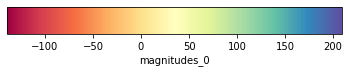

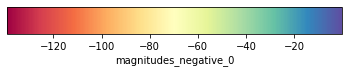

In [16]:
for ts_dir in run_dict:
    
    print("dir" , ts_dir)
    save_location = base_output_dir + "/" + ts_dir
    tiles_data = run_dict[ts_dir]
    
    # Print statistics
    perc_lacking_data_sum, perc_breaks_sum= 0,0
    for tile in tiles_data:
        minus2count,minus1count,perc_lacking_data,perc_breaks = tile.check_arrays()
        perc_breaks_sum += perc_breaks
        perc_lacking_data_sum+= perc_lacking_data
        
    print("percentage breaks found", perc_breaks_sum/len(tiles_data))
    print("percentage cells lacking data to find results found", perc_lacking_data_sum/len(tiles_data) , "\n")
    
    # Merge tiles
    if len(tiles_data) > 1:
        means_orig, breaks_orig = merge_tiles(tiles_data,output_dir_name = save_location)
    else:
        means_orig = tiles_data[0].means_array
        breaks_orig = tiles_data[0].breaks_array

    # Export magnitudes and breaks
    save_plot(means_orig, save_location, save_name = "magnitudes_" + ts_dir)
    export_GTiff(tiles_data, output_dir = save_location, array = means_orig, output_name = "magnitudes_" + ts_dir)
    export_GTiff(tiles_data, output_dir = save_location, array = breaks_orig, output_name = "breaks_indexed_" + ts_dir)

    # Classify means 
    classified_means = classify_magnitudes(means_orig)
    classified_means = np.nan_to_num(classified_means,nan=0).astype("uint16")
    export_GTiff(tiles_data, output_dir = save_location, array = classified_means, output_name = "magnitudes_classified_" + ts_dir)
    
    # add colors to classified raster
    func = "oft-addpct.py"
    output_key = save_location.replace("/","-").split("-")[1]
    clas_tif = save_location + "/geotifs/magnitudes_classified_" + ts_dir + "_" + output_key + ".tif"
    clas_tif_result = save_location + "/geotifs/magnitudes_classified_" + ts_dir + "_" + output_key + "_result.tif"
    color_table = "color_table.txt"
    
    ps = subprocess.Popen(('echo', color_table), stdout=subprocess.PIPE)
    output = subprocess.check_output((func, clas_tif, clas_tif_result), stdin=ps.stdout)
    ps.wait()
    
    # select only negative magnitudes
    means_neg, breaks_indexed, breaks_indexed_neg, binary_breaks, negative_binary_breaks = select_negatives(means_orig, breaks_orig)
    save_plot(means_neg, output_dir = save_location, save_name = "magnitudes_negative_" + ts_dir)

    # save negative means and breaks
    export_GTiff(tiles_data, output_dir = save_location, array = means_neg ,output_name = "magnitudes_negative_" + ts_dir)
    export_GTiff(tiles_data, output_dir = save_location, array = binary_breaks ,output_name = "breaks_binary_" + ts_dir)
    export_GTiff(tiles_data, output_dir = save_location, array = negative_binary_breaks ,output_name = "breaks_binary_negative_" + ts_dir)

    dates_monitor = []
    dates = tiles_data[0].cropped_dates

    # collect dates for monitor period
    for i in range(len(dates)):
        if start_monitor <= dates[i]:
            dates_monitor.append(dates[i])
    dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period
    
    # julian_date output
    julian_breaks, year_breaks = get_julian_dates(dates_array,breaks_indexed)
    negative_julian_breaks, negative_year_breaks = get_julian_dates(dates_array,breaks_indexed_neg)

    # save negative means and breaks
    export_GTiff(tiles_data, output_dir = save_location, array = julian_breaks ,output_name = "breaks_julian_" + ts_dir)
    export_GTiff(tiles_data, output_dir = save_location, array = negative_julian_breaks ,output_name = "breaks_julian_negative_" + ts_dir)

    export_GTiff(tiles_data, output_dir = save_location, array = year_breaks, output_name = "breaks_year_" + ts_dir)
    export_GTiff(tiles_data, output_dir = save_location, array = negative_year_breaks, output_name = "breaks_year_negative_" + ts_dir)

### Display webmap and store as .html

In [17]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', layout=Layout(height='auto', width='500px'), option…

In [18]:
if not plot_display_data_chooser.result:
    print("make sure to run the block above")

m = merge_plots2(data_list = run_dict[ts_dir], base_output_dir=base_output_dir,plot_name= plot_display_data_chooser.result)
m.save(base_output_dir + "/" +"0/" + plot_display_data_chooser.result + ".html")
m

0
stored_time_series/today/0/pngs/magnitudes_0.png
